In [45]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
import torch.optim as optim
import graphviz
import math
import os
os.environ["PATH"] = "/opt/local/bin:" + os.environ["PATH"]
from graphviz import Digraph
import random

In [2]:
import os
print(os.environ["PATH"])

/opt/local/bin:/Users/mikuangyi/Desktop/RecoveredDesktop_Archive-1/ak-neural-network/ak_venv/bin:/Library/Frameworks/Python.framework/Versions/3.12/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Applications/VMware Fusion.app/Contents/Public


In [3]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [4]:
class Value:
      
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out

  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

20


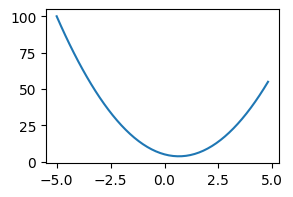

In [5]:
def f(x):
    return 3*x**2 - 4*x + 5
y = f(3)
print(y)
x_list = np.arange(-5, 5, 0.2)
y_list = [f(x) for x in x_list]
plt.figure(figsize = (3,2))
plt.plot(x_list, y_list)


In [6]:
## L = ab + c ##
a = 2
b = -3
c = 10
f = -2
e = a*b 
d = e + c
L = d*f

In [7]:
## approximate partial derivative with delta (direct)
delta = 0.0001

f_ = f + delta
L_ = d*f_
dLdf = (L_ - L)/ delta
print('dL/df = ', f"{dLdf:.4f}") 
print('---------------')
d_ = d + delta 
L_ = d_*f 
dLdd = (L_ - L)/ delta
print('dL/dd = ', f"{dLdd:.4f}")
print('---------------')
e_ = e + delta 
L_ = (e_ + c) * f 
dLde  = (L_ - L)/ delta
print('dL/de = ', f"{dLde: .4f}") 
print('---------------')
c_ = c + delta 
L_ = (e + c_) * f
dLdc = (L_ - L)/ delta
print('dL/dc = ', f"{dLdc: .4f}") 
print('---------------')
a_ = a + delta 
L_ = ((a_*b) + c) * f
dLda = (L_ - L)/ delta
print('dL/da = ', f"{dLda: .4f}") 
print('---------------')
b_ = b + delta 
L_ = ((a*b_) + c) * f
dLdb = (L_ - L)/ delta
print('dL/db = ', f"{dLdb: .4f}")


dL/df =  4.0000
---------------
dL/dd =  -2.0000
---------------
dL/de =  -2.0000
---------------
dL/dc =  -2.0000
---------------
dL/da =   6.0000
---------------
dL/db =  -4.0000


In [8]:
## approximate partial derivative with delta (chain rule)
delta = 0.0001

f_ = f + delta
L_ = d*f_
dLdf = (L_ - L)/ delta
print('dL/df = ', f"{dLdf:.4f}") 
print('---------------')
d_ = d + delta 
L_ = d_*f 
dLdd = (L_ - L)/ delta
print('dL/dd = ', f"{dLdd:.4f}")
print('---------------')
e_ = e + delta
d_ = e_ + c 
ddde = (d_ - d)/(e_ - e)
dLde = dLdd * ddde
print('dL/de = ', f"{dLde: .4f}") 
print('---------------')
c_ = c + delta 
d_ = (e + c_)
dddc = (d_ - d)/(c_ - c)
dLdc = (L_ - L)/ delta
print('dL/dc = ', f"{dLdc: .4f}") 
print('---------------')
a_ = a + delta 
e_ = (a_*b)
deda = (e_ - e) / (a_ - a)
dLda = dLdd * ddde * deda
print('dL/da = ', f"{dLda: .4f}") 
print('---------------')
b_ = b + delta 
e_ = (a*b_)
dedb = (e_ - e) / (b_ - b)
dLdb = dLdd * ddde * dedb
print('dL/db = ', f"{dLdb: .4f}")


dL/df =  4.0000
---------------
dL/dd =  -2.0000
---------------
dL/de =  -2.0000
---------------
dL/dc =  -2.0000
---------------
dL/da =   6.0000
---------------
dL/db =  -4.0000


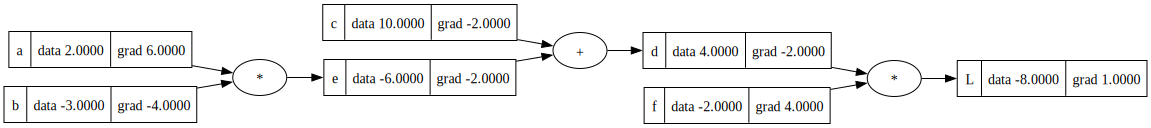

In [10]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

L.grad = 1.0
f.grad = dLdf
d.grad = dLdd
e.grad = dLde
c.grad = dLdc
a.grad = dLda
b.grad = dLdb

draw_dot(L)

In [15]:
x1 = Value(2.0, label = 'x1')
x2 = Value(1.0, label =  'x2')

w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
b = Value(7.0, label = 'b')

x1w1 = x1*w1
x1w1.label = 'x1w1'
x2w2 = x2*w2
x2w2.label = 'x2w2'

xw = x1w1 + x2w2
xw.label = 'xw'

z = xw + b 
z.label = 'z'

a = z.tanh()
a.label = 'a'


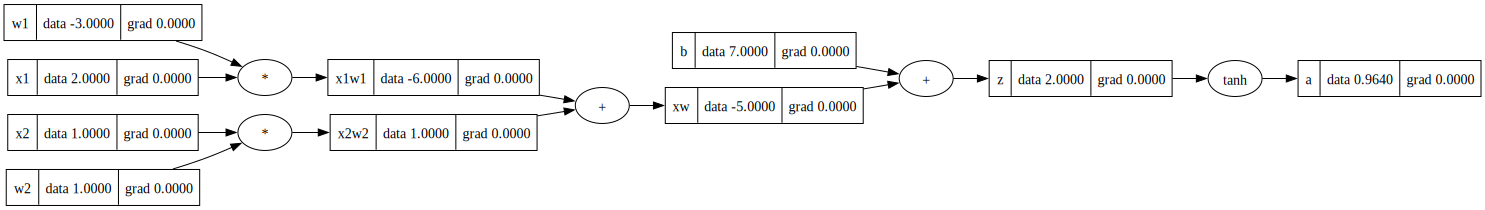

In [16]:
draw_dot(a)

In [18]:
a.backward()

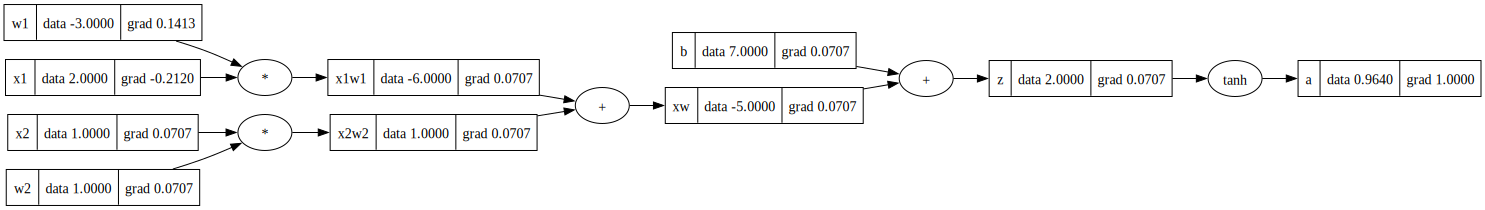

In [19]:
draw_dot(a)

In [43]:
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([1.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b =  torch.Tensor([7.0]).double()
b.requires_grad = True
z = w1*x1 + w2*x2 + b 
a = torch.tanh(z)
print(a)
a.backward()

print(w1.grad)
print(x1.grad)
print(x2.grad)
print(w2.grad)

tensor([0.9640], dtype=torch.float64, grad_fn=<TanhBackward0>)
tensor([0.1413], dtype=torch.float64)
tensor([-0.2120], dtype=torch.float64)
tensor([0.0707], dtype=torch.float64)
tensor([0.0707], dtype=torch.float64)


In [59]:
class Neuron:

    def __init__(self, input_dim):
        self.w = [Value(random.uniform(-1,1)) for _ in range(input_dim)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # z = sum(wi * xi for wi, xi in zip(self.w, x)) + self.b
        z = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        a = z.tanh()
        return a 
    
    def parameters(self):
        return self.w + [self.b]
    

In [85]:
n_test = Neuron(5)
print(len(n_test.parameters()))
n_test.parameters()
## w size = 5 per neuron & b size = 1 per neuron ##

6


[Value(data=0.5331169946758114),
 Value(data=0.26880803132287157),
 Value(data=0.8613351406224408),
 Value(data=-0.4858947076851452),
 Value(data=-0.022369470968963467),
 Value(data=0.07876597406984809)]

In [76]:
class Layer:

    def __init__(self, input_dim, output_dim):
        self.neurons = [Neuron(input_dim) for _ in range(output_dim)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]


In [84]:
layer_test = Layer(3,4)
print(len(layer_test.parameters()))
layer_test.parameters()
## w size = 12 + b size = 4 ##

16


[Value(data=-0.2753668657929167),
 Value(data=-0.6358464591595305),
 Value(data=0.9282344299935179),
 Value(data=-0.6580409407496037),
 Value(data=0.052569301068415175),
 Value(data=-0.14728806379011172),
 Value(data=-0.696721873868583),
 Value(data=-0.06756123200936948),
 Value(data=0.9836282119862789),
 Value(data=-0.7730465095581074),
 Value(data=0.6329447256059144),
 Value(data=0.41438928898998517),
 Value(data=-0.2850424151424511),
 Value(data=-0.2620755124941201),
 Value(data=-0.6733266109080285),
 Value(data=-0.6903829730515494)]

In [61]:
class MLP:

    def __init__(self, input_dim,  layer_dims):
        self.nn_structure = [input_dim] + layer_dims
        self.layers = [Layer(self.nn_structure[i],self.nn_structure[i+1]) for i in range(len(self.nn_structure)-1)]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x 
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [86]:
mlp_test = MLP(3, [2,2,3])
print(len(mlp_test.parameters()))
len(mlp_test.parameters())


23


23

In [88]:
## above MLP handles ONE x element at a time ##
x = [2.0, 3.0, -1.0]
nets = MLP(3, [3, 5, 1])
nets(x)
print(len(nets.parameters()))

38


In [90]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] 

In [93]:
for k in range(20):
  
  ypred = [nets(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in nets.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in nets.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 7.297099926295463
1 2.6130339806314664
2 5.280194407457744
3 7.440748218573182
4 0.9843844185837125
5 0.04603003860245669
6 0.02330894417435911
7 0.016905492418564698
8 0.013563156533586201
9 0.011461800455958491
10 0.010002346346025605
11 0.008922443653125728
12 0.008087261998857375
13 0.007419827162207621
14 0.006872764932542059
15 0.0064152166632867385
16 0.006026167068492854
17 0.005690781114372027
18 0.005398271545901721
19 0.005140596712444645
